# This is The Title of Notebook
### Purpose
In this notebook I will create an example header and show how to structure the notebooks for easy readaility and documentation. 

In short, we are trying to follow the conventions of Cookie Cutter Data Science: https://drivendata.github.io/cookiecutter-data-science/ 

#Temperature Accuracy Analysts
 
 * [ ] How many circles are between the temp min and temp max of a noaa station? How many are not?
 * [ ] Plots of Temperature NOAA, Temperature circle as a function of time for some circles
 * [ ] Plot (T_NOAA-T_circle)
 * [ ] Temperature Measurement Goodness with Interchangeable Metric
   
   ----- Example Metric. Will says we should consider something like dT=sqrt( (T_N,min-TC,min)^2+(T_N,max-TC_max)^2). -- This would be a measure of how far off the NOAA data and Circle data differ.  The squares are because we care about magnitude of difference, not sign of difference. Then we define a range that we will say is "good". Example If dT< 5 we mark the circle as good for that year
   ---- plot these on a map with the outliers in one color and the good stations in another color to see if there is any geographic clustering for "good" vs "bad"
   ---- _**Note on Building the Notebook**_  Will believes that the best thing we can do for audubon is to pass them a notebook to allow them to easily define the metrics and range on if the Temperature for each circle is within an defined metric. So when we do this analysis and build our metrics and ranges, we should construct the notebook such that it is easy for us and Audubon to switch out these values. Pretty similar to how we define static variables at the top  of our notebooks for file names.
   
 * [ ]  Provide an opinion to this statement: CBC volunteers are NOT good resources for temperature data.
 * [ ]  Optional: Have Metric and Threshold analysis Breakdown by Ecosystem
 * [ ]  Optional: Have Metric and Threshold analysis Breakdown by set distance threshold
 
 # Deliverable
 * Deliverable for the Audubon society will be a list of circles but we think the data is accurate.
 * FAQ Sections
   ----- What is happening in the 20 - 70 with temp?
 
 ----- Some of the min_temps that have errors look like they are cases where the circle value is listed as 0. Is it possible that this was either a data entry error, or when someone left it blank, it somehow got a zero filled in?
 
 Notes:
 Only use CBC circles that have NOAA stations attached



### Author: 
Jacob Ellena
### Date: 
2020-07-30
### Update Date: 
2020-07-30

### Inputs 
1.3-rec-connecting-fips-ecosystem-data.txt -  
Example
cbc_effort_weather_1900-2018.txt - Tab seperated file of Christmas Bird Count events going back to 1900. Each row represents a single count in a given year. Data Dictonary can be found here: http://www.audubon.org/sites/default/files/documents/cbc_report_field_definitions_2013.pdf

### Output Files
This is where you list any files or artifcats this notebook produces. Please also give a short summary of the data 

DataFiles should be named after the notebook when possible, ie this notebook might produce the file 0.0-rec-example-notebook-with-header.csv 


## Steps or Proceedures in the notebook 
This is where you list what you did in the notebook. The goal is that someone who has never coded in their life can understand what you did. Pro Tip -- if you are working off of an Github issue, this is a great place to put those check boxes! 
- Create an Example Header 
- Create an example of Loading Data 


## Where the Data will Be Saved 
All data for this project will be saved in Google Drive. To start experimenting with data, download the folder hear and put it into your data folder.
https://drive.google.com/drive/folders/1Nlj9Nq-_dPFTDbrSDf94XMritWYG6E2I

The path should look like this: 
audubon-cbc/data/Cloud_Data/<DATA FILE>

In [ ]:
# Imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

#Options
pd.set_option("display.max_columns", 100)

In [ ]:
# ALL File Paths should be declared at the TOP of the notebook
PATH_TO_RAW_CBC_DATA = "../data/Cloud_Data/1.3-rec-connecting-fips-ecosystem-data.txt"

In [ ]:
raw_data = pd.read_csv(PATH_TO_RAW_CBC_DATA, encoding = "ISO-8859-1", sep="\t", compression='gzip')

In [ ]:
raw_data.head()

In [ ]:
# Pulling out temperature data and renaming columsn for clarification
temp_df_raw = raw_data[['count_year',
                    'circle_name', 
                    'circle_id',
                    'lat',
                    'lon',
                    'min_temp',
                    'max_temp',
                    'id',
                    'latitude',
                    'longitude',
                    'temp_min_value',
                    'temp_max_value']]

#Setting temp_df to be a copy to avoid indexing erros
temp_df = temp_df_raw.copy()

temp_df.rename(columns={
    'lat':'circle_lat',
    'lon':'circle_lon',
    'min_temp':'circle_min_temp',
    'max_temp':'circle_max_temp',
    'temp_unit':'circle_temp_unit',
    'id':'noaa_id',
    'latitude':'noaa_lat',
    'longitude':'noaa_lon',
    'temp_min_value':'noaa_min_temp',
    'temp_max_value':'noaa_max_temp'},
    inplace=True
              )
#Setting number of rows for comparison of how much data is lost after cleaning
row_count = temp_df.shape[0]
temp_df.head()

## EDA Notes
In order to compare temperature between CBC Circles and NOAA Stations several cleaning steps are needed
1. Compare only CBC Circles with NOAA Stations Attached
2. Remove rows with no data for either CBC Circle or NOAA Station
3. Create averages for both Circles and Stations for comparisons
4. Remove all rows with temperatures outside of max temperature bounds

#### EDA Note 1
Checking number of rows without a CBC Circle or NOAA station

In [ ]:
print(f" Number of rows without a CBC Circle is:   {temp_df['circle_id'].isna().sum()}")
print(f" Number of rows without a NOAA Station is: {temp_df['noaa_id'].isna().sum()}")

#### EDA Note 2
Removing rows without temperature data for either CBC Circles or NOAA stations.

In [ ]:
temp_df.dropna(axis=0, subset=['circle_min_temp', 'circle_max_temp', 'noaa_min_temp', 'noaa_max_temp'], inplace=True)
print(f"Number of rows before: {row_count}")
print(f"Number of rows after:  {temp_df.shape[0]}")
print(f"Total removed:         {row_count - temp_df.shape[0]}")

#### EDA Note 3 
Generating Averages

In [ ]:
temp_df['circle_average'] = (temp_df['circle_min_temp'] + temp_df['circle_max_temp'])/2
temp_df['noaa_average'] = (temp_df['noaa_min_temp'] + temp_df['noaa_max_temp'])/2

### Checking to see how many CBC Circle temperatures records are within the bounds of the NOAA Station records

In [ ]:
temp_df['temp_check'] = temp_df['circle_average'].between(temp_df['noaa_min_temp'], temp_df['noaa_max_temp'])

In [ ]:
# Counting number of circles that are true
temp_true = sum(temp_df['temp_check'])
temp_false = temp_df.shape[0] - sum(temp_df['temp_check'])
print(f"Number of CBC Cirlcs who's temperature is in the bounds of the corresponding NOAA station:     {sum(temp_df['temp_check'])}")
print(f"Number of CBC Cirlcs who's temperature is not in the bounds of the corresponding NOAA station: {temp_df.shape[0] - sum(temp_df['temp_check'])}")
print()
print(f"{round((temp_true/temp_df.shape[0])*100)}% of stations lay between")

#### EDA Note 4 
There are a number of outliers in the data set that could highly skew analysis. Any rows with a temperature outside of a min or max recorded temperature in the United States will be dropped.

To be conservative in data dropping we'll only using on max and one min for the entire country rather then by state or other locality. Additionally we'll check by each min/max temp for cirlces and stations to get an idea on if one is more disperate then another.

Data: https://en.wikipedia.org/wiki/U.S._state_and_territory_temperature_extremes

In [ ]:
# Setting the max and min temperatures
max_temp_check = 134 # Death Valley California
min_temp_check = -80 # Fort Yukon Alaska

In [ ]:
# Creating variables for each drop condition
circle_over_max_temp  = temp_df.loc[temp_df["circle_max_temp"]>max_temp_check]
circle_under_min_temp = temp_df.loc[temp_df["circle_min_temp"]<min_temp_check]
noaa_over_max_temp    = temp_df.loc[temp_df["noaa_max_temp"]>max_temp_check]
noaa_under_min_temp   = temp_df.loc[temp_df["noaa_min_temp"]<min_temp_check]


print(f'Number of CBC measurments outside max  : {circle_over_max_temp.shape[0]}')
print(f'Number of NOAA measurments outside max : {circle_under_min_temp.shape[0]}')
print()
print(f'Number of CBC measurments outside min  : {noaa_over_max_temp.shape[0]}')
print(f'Number of NOAA measurments outside min : {noaa_under_min_temp.shape[0]}')
print()
print(f'Number of NOAA stations with both outside : {temp_df.loc[(temp_df["noaa_max_temp"] > max_temp_check) & (temp_df["noaa_min_temp"] < min_temp_check)].shape[0]}')

In [ ]:
# Setting list of indices to drop
index_drop_list = list(circle_over_max_temp.index) + list(circle_under_min_temp.index) + list(noaa_over_max_temp.index) + list(noaa_under_min_temp.index)

In [ ]:
# Dropping Rows
temp_df.drop(index_drop_list, inplace=True)

In [ ]:
temp_df.shape

---
# Plotting over time
Circles have multiple matching stations per year.

In [ ]:
#Finding top 10 most common circles to compare to NOAA data over time.
most_active_circles_list = temp_df['circle_id'].value_counts()[:10].index.tolist()

In [ ]:
# Finding matching NOAA stations
temp_df.loc[temp_df['circle_id'] == most_active_circles_list[0]]

---
## Plotting out CBC Circle temperature data to NOAA Station data

In [ ]:
plt.figure(figsize=(20, 6))
sns.scatterplot(x=temp_df['circle_average'], y=temp_df['noaa_average'])
plt.title('CBC Average Temp to NOAA Station Average Temp', fontsize=20)
plt.xlabel('Average CBC Circle Temp', fontsize=10)
plt.ylabel('Average NOOA Station Temp', fontsize=10)
;

In [ ]:
temp_df.loc[temp_df['noaa_average']]

---
## Temperature Measurement Goodness with Interchangeable Metric

temp_metric = sqrt( (noaa_min_temp - circle_min_temp)^2 + (noaa_max_temp - circle_max_temp)^2 )

Going to compare two different metrics to get and idea of how varied they could be

### Metric 1
temp_metric_1 = sqrt( (noaa_min_temp - circle_min_temp)^2 + (noaa_max_temp - circle_max_temp)^2 )

In [14]:
temp_df['temp_metric_1'] = round(np.sqrt(((temp_df['noaa_min_temp'] - temp_df['circle_min_temp'])**2) + ((temp_df['noaa_max_temp'] - temp_df['circle_max_temp'])**2)),2)

### Metric 2
temp_metric_2 = sqrt( (noaa_average - circle_average)^2 )

In [15]:
temp_df['temp_metric_2'] = np.sqrt((temp_df['noaa_average'] - temp_df['circle_average'])**2)

In [16]:
temp_df.sort_values(by=['temp_metric_1'])

,count_year,circle_name,circle_id,circle_lat,circle_lon,circle_min_temp,circle_max_temp,noaa_id,noaa_lat,noaa_lon,noaa_min_temp,noaa_max_temp,circle_average,noaa_average,temp_check,temp_metric_1,temp_metric_2
325401,2004,Snake Valley,9qyv7pz,38.934646,-114.116122,22.0,39.0,USC00263340,39.0056,-114.2206,22.0,39.0,30.5,30.5,True,0.00,0.0
747412,2013,Padilla Bay,c28gffj,48.483361,-122.566733,34.0,45.0,USW00024255,48.3500,-122.6667,33.0,44.0,39.5,38.5,True,1.41,1.0
271338,2010,East Contra Costa County,9q9rxjs,37.911751,-121.678041,30.0,60.0,USR0000CMTD,37.8817,-121.9142,28.0,61.0,45.0,44.5,True,2.24,0.5
491064,2004,Ramsey,dr71y2c,41.093508,-74.254139,31.0,57.0,USC00289187,41.0444,-74.2933,28.0,56.0,44.0,42.0,True,3.16,2.0
255820,2011,Mount Hamilton,9q9sdem,37.371883,-121.522835,35.0,47.0,USR0000CDIA,37.3292,-121.2939,33.0,50.0,41.0,41.5,True,3.61,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147721,1988,Claremont,9qh61w8,34.138389,-117.707292,45.0,70.0,USR0000CTAN,34.2069,-117.7606,-500.0,-281.0,57.5,-390.5,False,648.25,448.0
142530,2008,Santa Cruz Island,9q4c6zd,34.011271,-119.758008,22.0,60.0,USR0000CDNO,34.0092,-119.6542,-483.0,-356.0,41.0,-419.5,False,654.28,460.5
275895,2004,Chincoteague N.W.R.,dqdruzx,37.967164,-75.366874,30.0,50.0,USR0000VCHI,37.9333,-75.3500,450.0,556.0,40.0,503.0,False,657.60,463.0
611525,1986,Casper,9xs76h3,42.783357,-106.433318,24.0,43.0,USS0006G01S,42.7300,-106.3200,1665.0,0.0,33.5,832.5,False,1641.56,799.0


### Catagories
Values in catagories can be changed and then applied to dataframe

In [17]:
# Creating Categories
excellent = 5
good      = 10
fair      = 15
poor      = 20

In [18]:
# Function to assign grade scores
def assign_grade(metric_score):
    if metric_score <= excellent:
        return 'excellent'
    elif metric_score <= good:
        return 'good'
    elif metric_score <= fair:
        return 'fair'
    else:
        return 'poor'

In [19]:
# Applying the scores
temp_df['metric_grade'] = temp_df['temp_metric_1'].apply(lambda metric_score: assign_grade(metric_score))

In [20]:
temp_df

,count_year,circle_name,circle_id,circle_lat,circle_lon,circle_min_temp,circle_max_temp,noaa_id,noaa_lat,noaa_lon,noaa_min_temp,noaa_max_temp,circle_average,noaa_average,temp_check,temp_metric_1,temp_metric_2,metric_grade
6,1968,Hawai'i: Volcano N.P.,8e3wd3w,19.433300,-155.283300,54.0,66.0,USC00511303,19.4297,-155.2561,100.0,189.0,60.0,144.5,False,131.32,84.5,poor
27,1973,Hawai'i: Volcano,8e3x40f,19.516651,-155.299965,37.0,75.0,USC00516552,19.5486,-155.1100,144.0,244.0,56.0,194.0,False,200.02,138.0,poor
32,1973,Hawai'i: Volcano,8e3x40f,19.516651,-155.299965,37.0,75.0,USC00515011,19.5494,-155.3011,83.0,167.0,56.0,125.0,False,102.86,69.0,poor
34,1974,Hawai'i: Volcano,8e3x40f,19.516651,-155.299965,55.0,70.0,USC00515011,19.5494,-155.3011,106.0,150.0,62.5,128.0,False,94.87,65.5,poor
39,1974,Hawai'i: Volcano,8e3x40f,19.516651,-155.299965,55.0,70.0,USC00516552,19.5486,-155.1100,156.0,289.0,62.5,222.5,False,241.17,160.0,poor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
756335,2016,Fairbanks,bewc5dt,64.877908,-147.846632,-1.0,32.0,USC00502871,64.9111,-147.9242,-117.0,-39.0,15.5,-78.0,False,136.00,93.5,poor
756338,2016,Fairbanks,bewc5dt,64.877908,-147.846632,-1.0,32.0,USC00503368,64.8939,-147.8753,-183.0,-83.0,15.5,-133.0,False,215.29,148.5,poor
756344,2017,Fairbanks,bewc5dt,64.877908,-147.846632,-5.0,22.0,USC00503368,64.8939,-147.8753,-222.0,-144.0,8.5,-183.0,False,273.21,191.5,poor
756349,2017,Fairbanks,bewc5dt,64.877908,-147.846632,-5.0,22.0,USC00502871,64.9111,-147.9242,-222.0,-133.0,8.5,-177.5,False,266.67,186.0,poor


---
## Plotting Circle Metric Scores by Lat/Lon

''

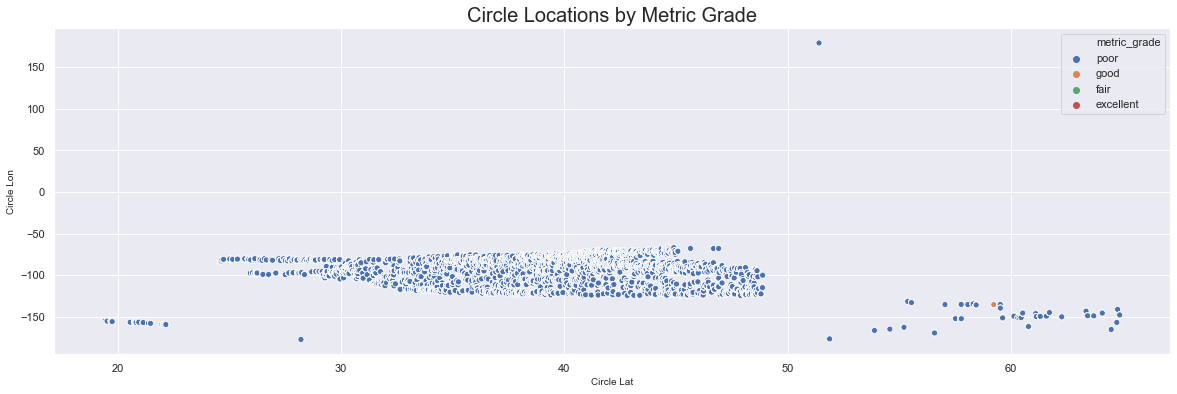

In [21]:
plt.figure(figsize=(20, 6))
sns.scatterplot(x='circle_lat', y='circle_lon', data=temp_df, hue='metric_grade')
plt.title('Circle Locations by Metric Grade', fontsize=20)
plt.xlabel('Circle Lat', fontsize=10)
plt.ylabel('Circle Lon', fontsize=10)
;

In [ ]:
Next Steps
Clean Data
Plot time series using closest station